In [0]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install scipy
!pip install pyclustering

    100% |████████████████████████████████| 2.5MB 14.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/81/ce/d19f3cba39e82fe3933680257b8df17160a57b596b4c680209
Successfully built pyclustering


In [0]:
# mount drive
from google.colab import drive
drive.mount('/content/drive') 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!rm -r data/action_db/training
!rm -r data/action_db/clusters
!rm -r plots
!rm plots.zip

rm: cannot remove 'plots.zip': No such file or directory


In [0]:
# create necessary directories 
import os
if not os.path.isdir('plots'):
  !mkdir plots
if not os.path.isdir('data'):
  !mkdir data

os.chdir('data')
if not os.path.isdir('action_db'):
  !mkdir action_db
os.chdir('action_db')
if not os.path.isdir('clusters'):
  !mkdir clusters
if not os.path.isdir('training'):
  !mkdir training
if not os.path.isdir('test'):
  !mkdir test
os.chdir('../../')

# load in dataset from drive
# from shutil import copyfile
# src = '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/train_data.csv' 
# dst = '/content/data/action_db/training/train_data.h5'
# copyfile(src, dst)




In [0]:
import sys
sys.setrecursionlimit(10000)

In [0]:
import numpy as np
import pandas as pd
import os
import ast
import numbers
from pyclustering.cluster import kmedians as pyclkmedians
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.utils import check_random_state
from sklearn.metrics.pairwise import pairwise_distances

joints = [
    'Hip',
    'RHip',
    'RKnee',
    'RFoot',
    'LHip',
    'LKnee',
    'LFoot',
    'Spine',
    'Thorax',
    'Neck/Nose',
    'Head',
    'LShoulder',
    'LElbow',
    'LWrist',
    'RShoulder',
    'RElbow',
    'RWrist'
]

def flatten_by_frame(df, csv=False):
    '''
    :param df: dataframe for particular emotion, containing one row per video
    :return: Flattened dataframe containing 1 row per frame
    '''

    def _convert_to_list(s):
        try:
            return ast.literal_eval(s)
        except:
            return [float(item) for item in s]


    cols_to_ignore = ['emotion', 'subject', 'action']
    if 'intensity' in df.columns:
        cols_to_ignore.append('intensity')
    if 'fold' in df.columns:
        cols_to_ignore.append('fold')
    df = df.drop(cols_to_ignore, axis=1)
    columns = df.columns.values
    split_df = pd.DataFrame(columns=columns)

    for i, row in df.iterrows():
        arr = np.array(row)
        if csv:
          arr = [_convert_to_list(r) for r in arr]
        arr = list(zip(*arr))
        arr = [np.array(row) for row in arr]
        df_temp = pd.DataFrame(arr, columns=columns)
        assert(len(df_temp.columns.values)==len(split_df.columns.values))
        split_df = split_df.append(df_temp)

    return split_df




def generate_lexicon(emotion, train, clusters_dir, left_out=None, k=5, override_existing_clusters=False, visualise_clusters=True):
    # obtain action sequences for emotion
    no_frames = len(train)
    # Check if need to carry out k-medians or clusters exist already
    if not os.path.isdir(clusters_dir):
      os.mkdir(clusters_dir)
    if left_out:
      file_path = clusters_dir + '/clusters_' + left_out + '_' + emotion + '.npz'
    else:
      file_path = clusters_dir + '/clusters_' + emotion + '.npz'
    if not os.path.isfile(file_path) or override_existing_clusters:
        print('Doing clustering')
        random_state = check_random_state(58)
        random_state = random_state.permutation(no_frames)[:k]
        initial_centers_ = train[random_state]
        k_medians = pyclkmedians.kmedians(data=train, initial_centers=initial_centers_, ccore = True, tolerance =0.0001)
        k_medians.process()
        predicted_centers=k_medians.get_medians()
        predicted_clusters = k_medians.get_clusters()
        predicted_clusters = [[train[i] for i in cluster] for cluster in predicted_clusters]
        print('Saving clusters to ' + file_path)
        np.savez_compressed(file_path, predicted_clusters=predicted_clusters,
                            predicted_centers=predicted_centers)
        print('Done.')
    else:
        clusters_data = np.load(file_path, encoding='latin1')
        predicted_clusters = clusters_data['predicted_clusters']

    if visualise_clusters:
        print('Visualising clusters for emotion %s...' %(emotion))
        print(len(predicted_clusters))
        plot_name = 'kmedians_' + str(left_out) + '_' + emotion + '.png' if left_out==None else 'kmedians_' + emotion + '.png'
        _visualise_clusters(clusters=predicted_clusters, plot_name=plot_name)

        
def _visualise_clusters(clusters, plot_name, show_plot=False):
        cmap = plt.cm.get_cmap('Pastel1', len(clusters)).colors
        labels = [[cmap[i] for j in range(len(cluster))] for i, cluster in enumerate(clusters)]
        labels = [l for label_arr in labels for l in label_arr]
        flat_clusters = [pt for cluster in clusters for pt in cluster]
        pca = PCA(n_components=2).fit(flat_clusters)
        pca_2d = pca.transform(flat_clusters)
        principalDf = pd.DataFrame(data=pca_2d
                                   , columns=['principal component 1', 'principal component 2'])

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlabel('Principal Component 1', fontsize=15)
        ax.set_ylabel('Principal Component 2', fontsize=15)
        ax.set_title('2 component PCA', fontsize=20)

        ax.scatter(principalDf.loc[:,'principal component 1'], principalDf.loc[:, 'principal component 2'], c=labels, s=50)

        ax.legend(labels)
        ax.grid()
        print('Saving plot...')
        plt.savefig('plots/' + plot_name)
        if show_plot:
            plt.show()
        print('Done')







Finding clusters for emotion ang
1648
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_ang.npz
Done.
Visualising clusters for emotion ang...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion fea
2072
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_fea.npz
Done.
Visualising clusters for emotion fea...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion hap
2806
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_hap.npz
Done.
Visualising clusters for emotion hap...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion neu
4128
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_neu.npz
Done.
Visualising clusters for emotion neu...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion sad
4197
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_sad.npz
Done.
Visualising clusters for emotion sad...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done
Finding clusters for emotion unt
4358
Doing clustering
Saving clusters to /content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters/clusters_unt.npz
Done.
Visualising clusters for emotion unt...
12


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Saving plot...
Done


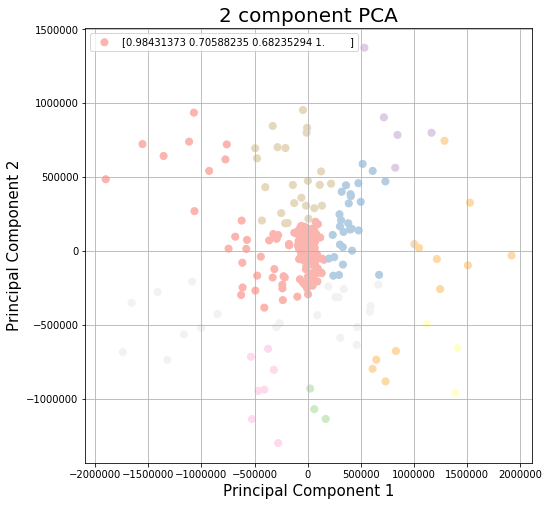

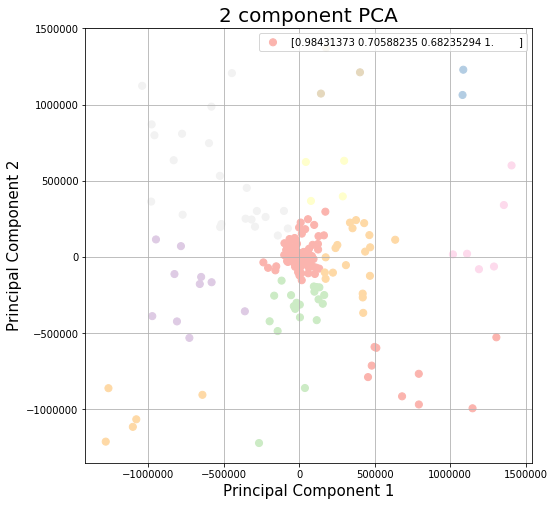

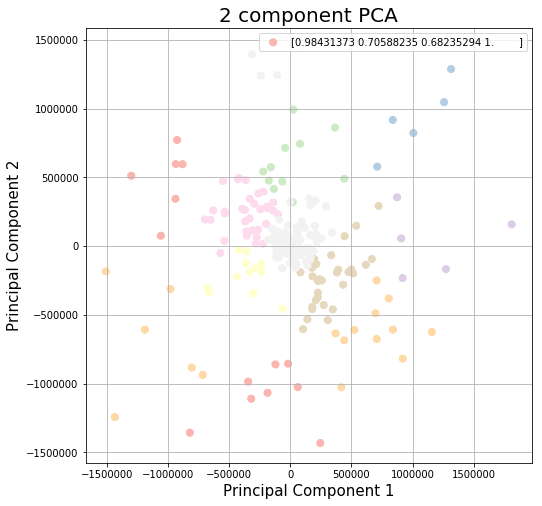

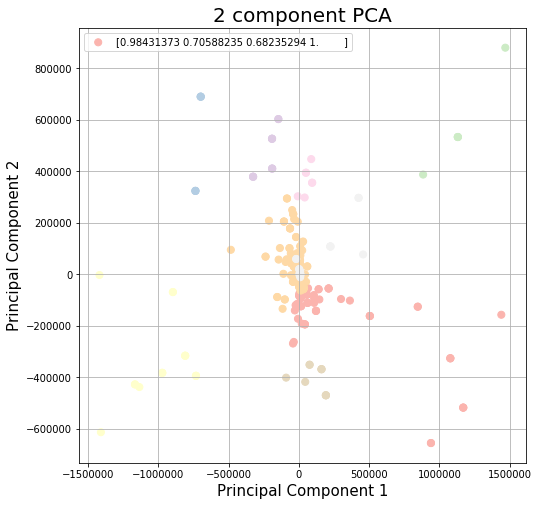

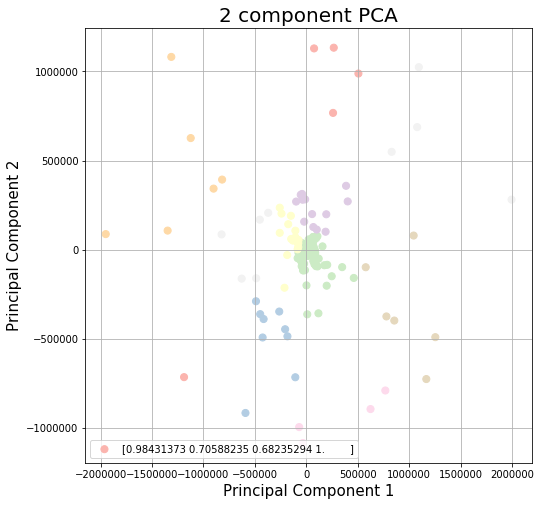

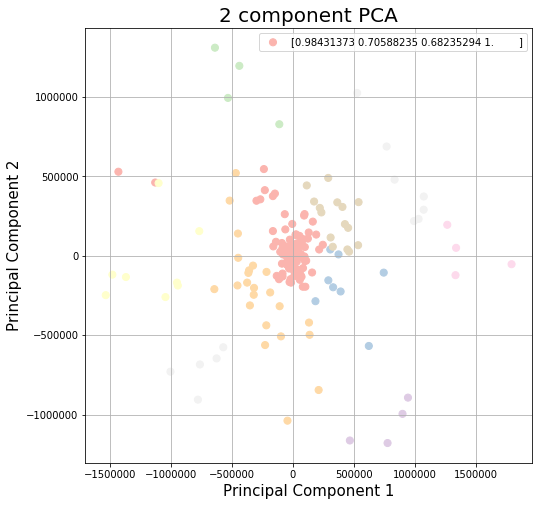

In [0]:
''' train, test '''
import os
emotions = ['ang', 'fea', 'hap', 'neu', 'sad', 'unt']
LMA_train = pd.read_csv('/content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/train_data.csv').iloc[:, 1:]

override_clusters = True  
for emotion in emotions:
    print('Finding clusters for emotion ' + emotion)
    df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/train_' + emotion + '.h5'
    if not os.path.isfile(df_path) or override_clusters:
        df = LMA_train.loc[LMA_train['emotion'] == emotion]
        df = flatten_by_frame(df, csv=True)
        # Write pandas dataframe to compressed h5.py file
        print(len(df))
        df.to_hdf(df_path, key='df', mode='w')
    else:
        df = pd.read_hdf(df_path)
    df_arr = np.array(df)
    generate_lexicon(emotion, df_arr, k=12, override_existing_clusters=True, clusters_dir='/content/drive/My Drive/Compsci II/Dissertation Project/action_db/train-test/clusters', visualise_clusters=True)

In [0]:
# Download files
from google.colab import files

!zip -r plots.zip plots
files.download('plots.zip')


  adding: plots/ (stored 0%)
  adding: plots/kmedians_unt.png (deflated 11%)
  adding: plots/kmedians_sad.png (deflated 11%)
  adding: plots/kmedians_ang.png (deflated 11%)
  adding: plots/kmedians_fea.png (deflated 10%)
  adding: plots/kmedians_hap.png (deflated 11%)


In [0]:
# downloading npz files directly fails so workaround is to copy to drive and download from there
files_to_copy = ['clusters/clusters_' + emotion + '.npz' for emotion in emotions]
files_to_copy += ['training/train_' + emotion + '.h5' for emotion in emotions]
files_to_copy = ['/content/data/action_db/' + file for file in files_to_copy]
from shutil import copyfile
for src in files_to_copy:
  dst = '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/' + os.path.basename(src)
  copyfile(src, dst)



10 fold cross validation

In [0]:
''' Prepare for 10 fold cross val '''

# create necessary directories 
import os
if not os.path.isdir('plots'):
  !mkdir plots
if not os.path.isdir('data'):
  !mkdir data

os.chdir('data')
if not os.path.isdir('action_db'):
  !mkdir paco
os.chdir('action_db')
if not os.path.isdir('clusters'):
  !mkdir clusters

os.chdir('../../')



In [0]:
# Split into folds
# !unzip '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/LMA_features_cross_val.h5.zip' 
import pandas as pd
df = pd.read_hdf('/content/drive/My Drive/Compsci II/Dissertation Project/action_db/LMA_features_cross_val.h5')
for i in range(10):
  print('Fold ' + str(i))
  df_test_fold_i = df.loc[df['fold']!=i]
  df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/LMA_features_test_fold_' + str(i) + '.csv'
  df_test_fold_i.to_csv(df_path)

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Fold 6
Fold 7
Fold 8
Fold 9


In [0]:
''' 10 fold cross val '''
from shutil import copyfile
import os
# emotions = ['ang', 'fea', 'hap', 'sad', 'neu', 'unt']
emotions = ['fea', 'unt']
no_folds = 10

for i in range(no_folds):
    print('Test fold: ' + str(i))
    
    df_path = '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/LMA_features_test_fold_' + str(i) + '.csv'
    LMA_train = pd.read_csv(df_path).iloc[:, 1:]
    for emotion in emotions:
        print('Finding clusters for emotion ' + emotion)
        df = LMA_train.loc[LMA_train['emotion'] == emotion]
        df = flatten_by_frame(df, csv=True)
        df_arr = np.array(df)
        clusters_dir='data/action_db/clusters/cross_val_' + str(i)
        generate_lexicon(emotion, df_arr, clusters_dir=clusters_dir, left_out=str(i), visualise_clusters=False)
        
    print('Copying clusters for fold ' + str(i))
    fold_files = ['/content/data/action_db/clusters/cross_val_' + str(i) + "/clusters_" + str(i) + "_" + emotion + ".npz" for emotion in emotions]
    for file in fold_files:
      clusters_path = '/content/data/action_db/clusters/cross_val_' + str(i)
      copyfile(file, '/content/drive/My Drive/Compsci II/Dissertation Project/action_db/10_fold_cross_val/' + os.path.basename(file))






Test fold: 0
Finding clusters for emotion fea
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion unt
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 0
Test fold: 1
Finding clusters for emotion fea
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion unt
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 1
Test fold: 2
Finding clusters for emotion fea
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion unt
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 2
Test fold: 3
Finding clusters for emotion fea
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion unt
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 3
Test fold: 4
Finding clusters for emotion fea
Doing clustering
Saving clusters...
Done.
Finding clusters for emotion unt
Doing clustering
Saving clusters...
Done.
Copying clusters for fold 4
Test fold: 5
Finding clusters for emotion fea